<center>

*******************************************************************************************
<font size="4">
Phase-Locking Value &nbsp; &nbsp; <br>
</font>

##### 8 August 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* "Phase-locking value" (PLV) is a measure for synchrony of two or more periodic or recurrent signals. In this context, synchrony is defined as a stable phase difference, either in a short lapse of time, or across a number of trials or conditions. The program below evaluates PLV upon a window in time.

>
* References:

    * Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J. (1999). Measuring phase synchrony in brain signals. *Human brain mapping, 8*(4), 194-208. https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C

    *  Mormann, F., Lehnertz, K., David, P., & Elger, C. E. (2000). Mean phase coherence as a measure for phase synchronization and its application to the EEG of epilepsy patients. *Physica D: Nonlinear Phenomena, 144*(3-4), 358-369. https://doi.org/10.1016/S0167-2789(00)00087-7

    * Bruña, R., Maestú, F., & Pereda, E. (2018). Phase locking value revisited: teaching new tricks to an old dog. *Journal of neural engineering, 15*(5), 056011. https://doi.org/10.1088/1741-2552/aacfe4
>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sys.path.append(r"..\src")
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


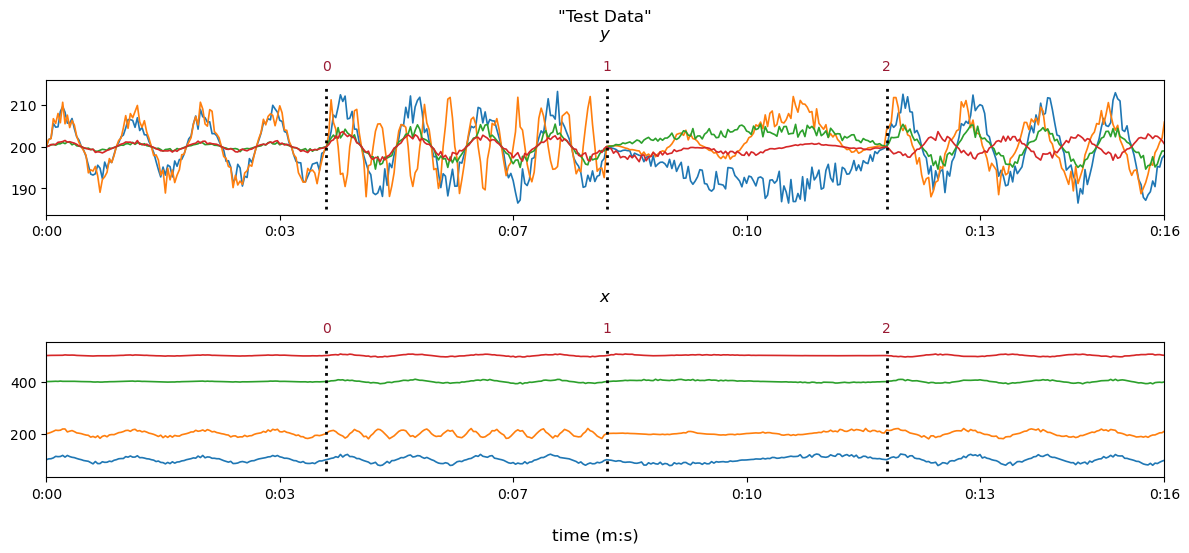

In [2]:
test_data_1 = sc.ptdata.load( 'make', seed=1, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

***
### Low-Pass Filter

In [3]:
apply_LPF = False # <---

filter_type = 'butter'
filter_freq_response = 'lowpass'
filter_cutoff_freq = 4 # <--- (Hz)
filter_order = 3       # <---

if apply_LPF:
    test_data_2 = sc.ptdata.smooth( test_data_1, filter_type=filter_type,
                                   freq_response=filter_freq_response,
                                   cutoff_freq=filter_cutoff_freq, order=filter_order )
    test_data_2.visualise( vscale=1.2, dlattr='1.2'  )
else:
    test_data_2 = test_data_1
    print('Filter not applied.')

Filter not applied.


***
### Reduce to 1 Dimension per point

Methods:
* Norms: the sum of the L1 and L2 norms preserve the shape of the oscillation and is not affected by noise.
* Speed: rectifies the oscillation and is affected by noise, leading to artifacts when applying the Fourier Transform.

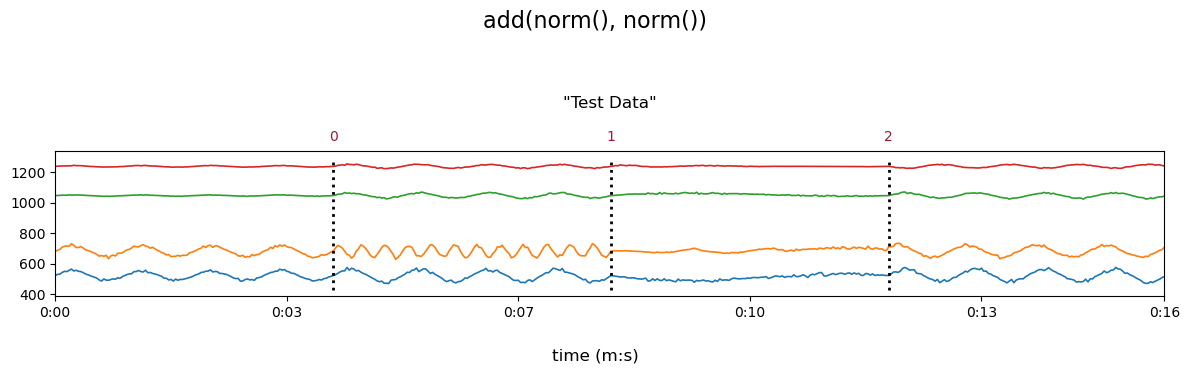

In [4]:
red1D_method = 'norms' # <--- 'norms' or 'speed'

if red1D_method == 'speed':
    test_data_3 = sc.ptdata.speed( test_data_2 )
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( test_data_2, order=1, axis=-2 )
    n2 = sc.ptdata.norm( test_data_2, order=2, axis=-2 )
    test_data_3 = sc.ptdata.apply2( n1, n2, np.add )
else: raise Exception('invalid value for red1D_method')
test_data_3.visualise( vscale=1.4, dlattr='1.2' )

***
### Phase

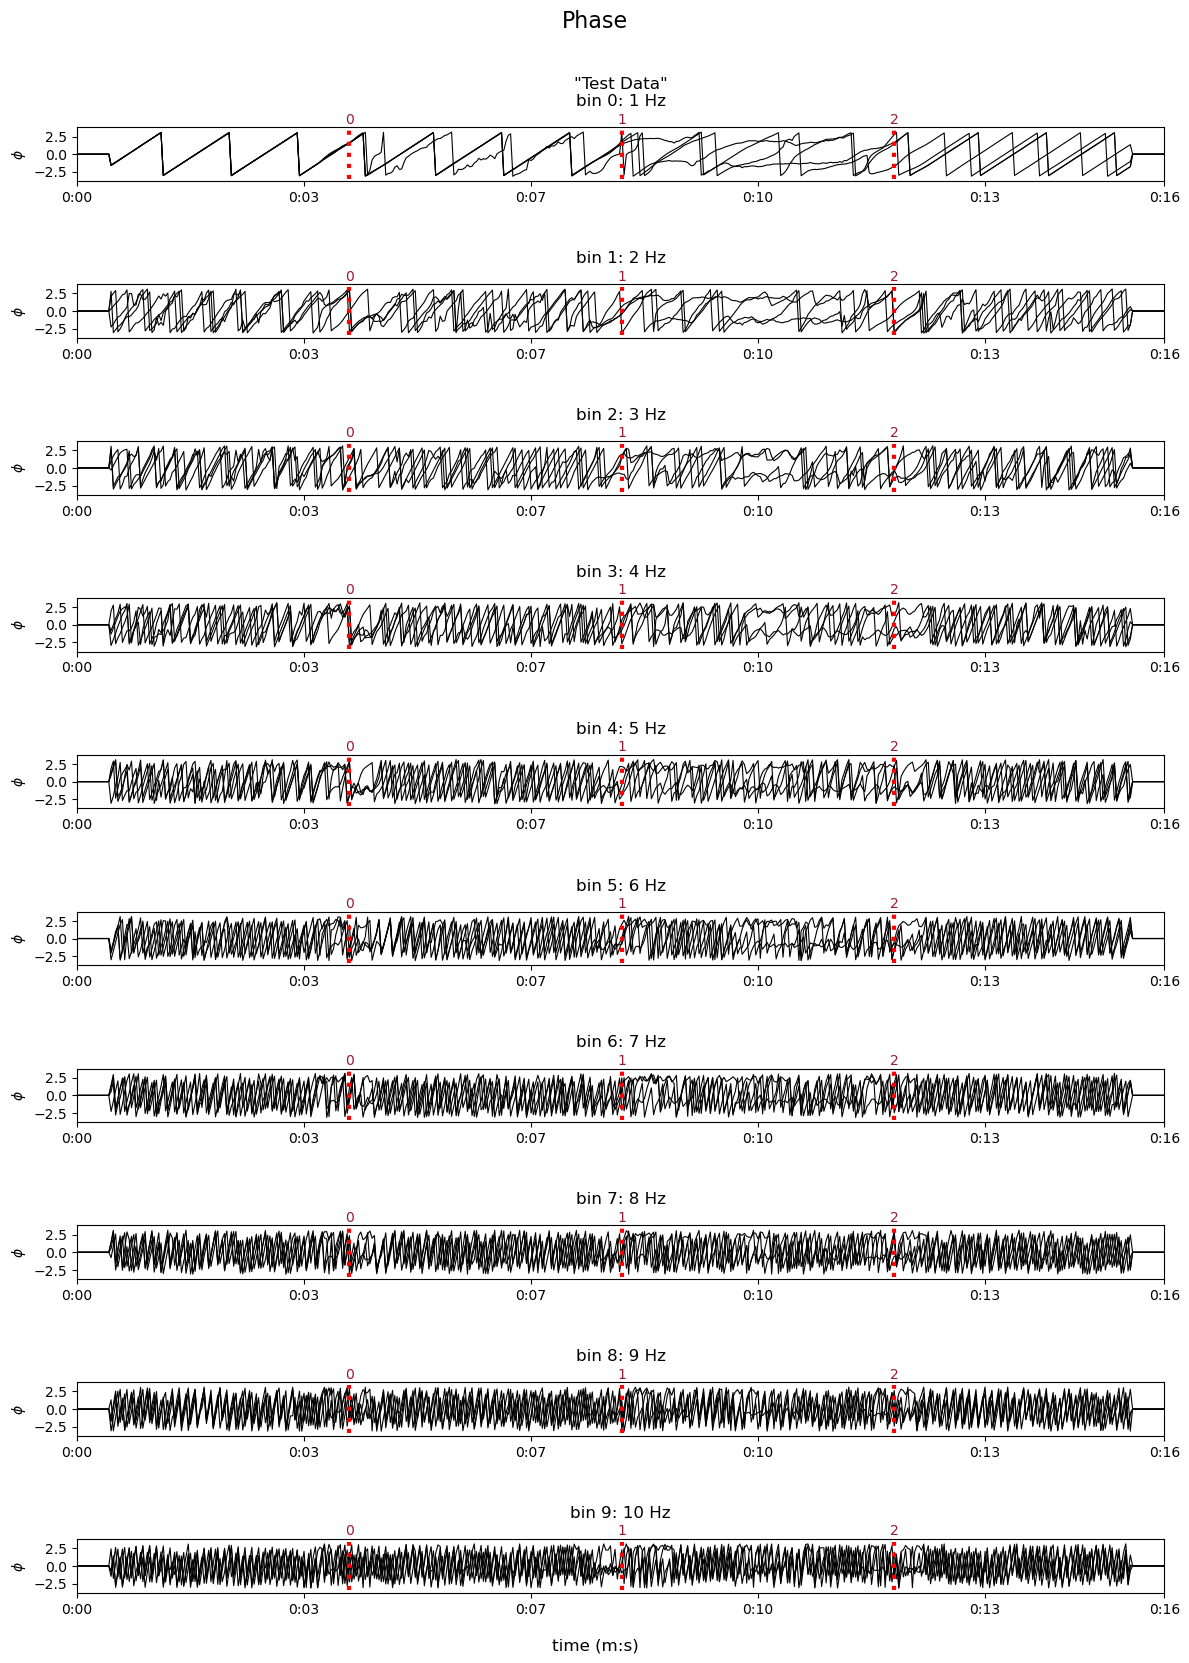

In [5]:
fft_window_s = 1           # <--- FFT window's length (seconds)
sel_freq_bin = slice(0,10) # <--- select frequency bins (int, slice, or 'all')

fft_phase = sc.ptdata.fourier( test_data_3, fft_window_s, output='phase' )
if sel_freq_bin == 'all':
    fft_phase.visualise( vscale=0.7 )
else:
    fft_phase = sc.ptdata.select(fft_phase,frequency=sel_freq_bin)
    if isinstance(sel_freq_bin,slice): fft_phase.visualise( vscale=0.7 )
    else: fft_phase.visualise( vscale=1.3 )

***
### Pairwise Multiband PLV

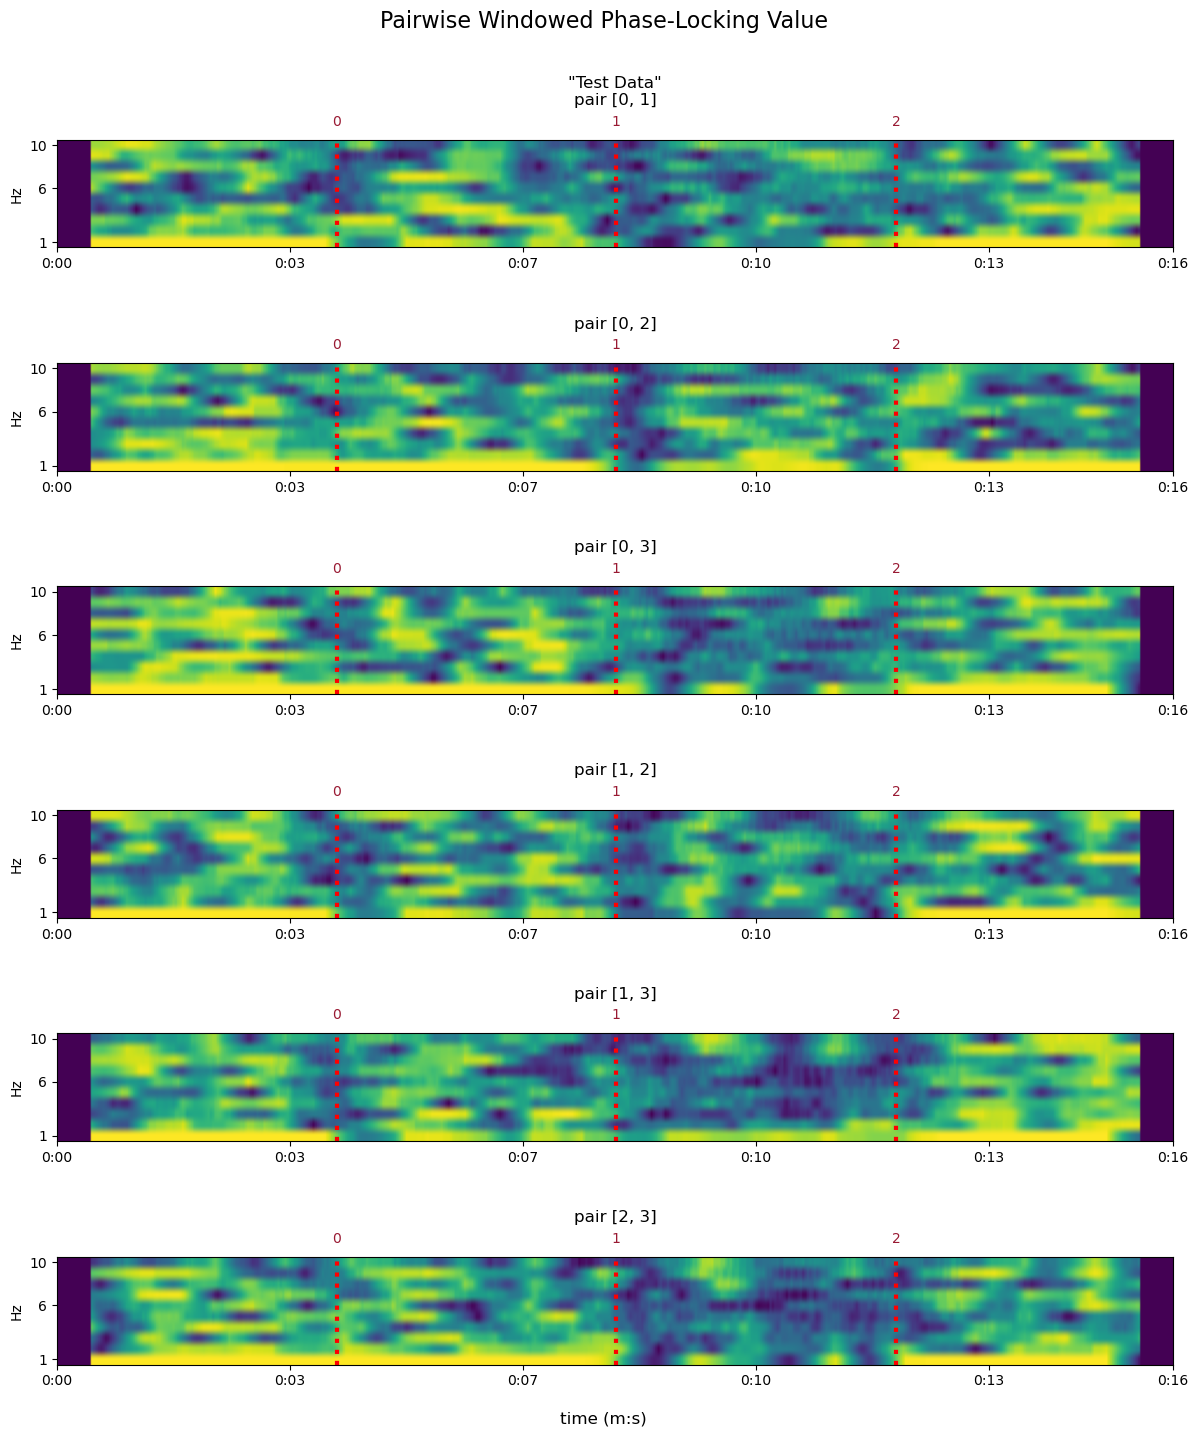

In [6]:
plv_window_s = fft_window_s # <--- (seconds)

wplv = sc.ptdata.winplv( fft_phase, plv_window_s )
wplv.visualise( dlattr='1.2' )

>
#### Average multiband PLV of group

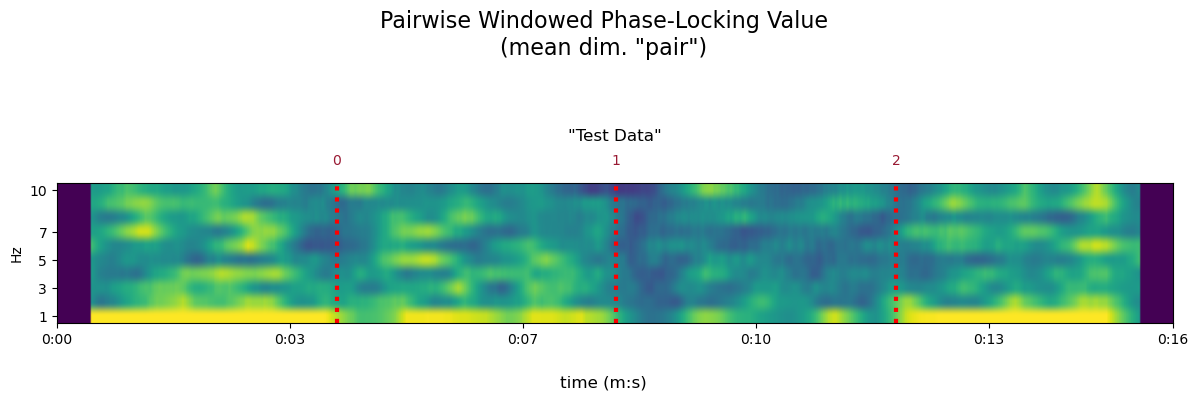

In [7]:
wplv_aggr_pairs = sc.ptdata.aggrax( wplv, axis=0, function='mean' )
wplv_aggr_pairs.visualise( vscale=1.4, dlattr='1.2' )

>
#### Band-average PLV of group

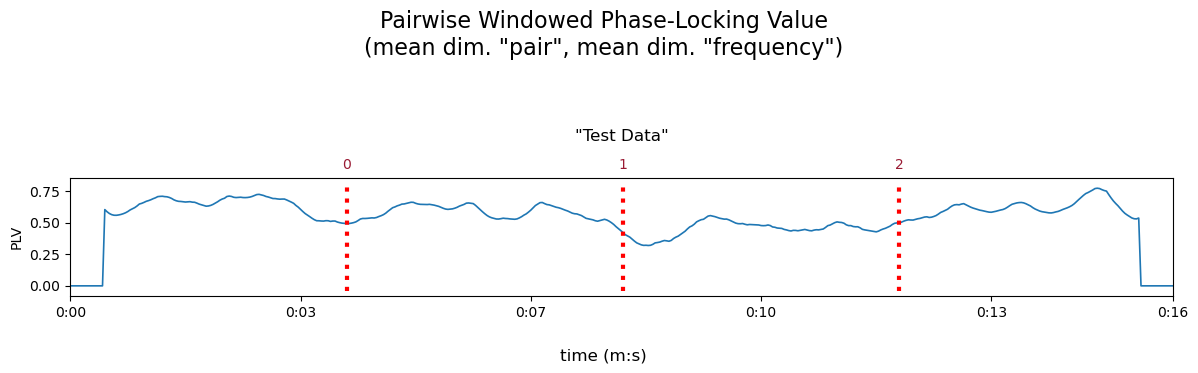

In [8]:
if isinstance(sel_freq_bin,int):
    print('Process does not apply.')
    wplv_aggr_top_sel = wplv_aggr_pairs
else:
    wplv_aggr_top_sel = sc.ptdata.aggrax( wplv_aggr_pairs, axis=0, function='mean' )
    wplv_aggr_top_sel.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

means = [0.683, 0.603, 0.482, 0.638]


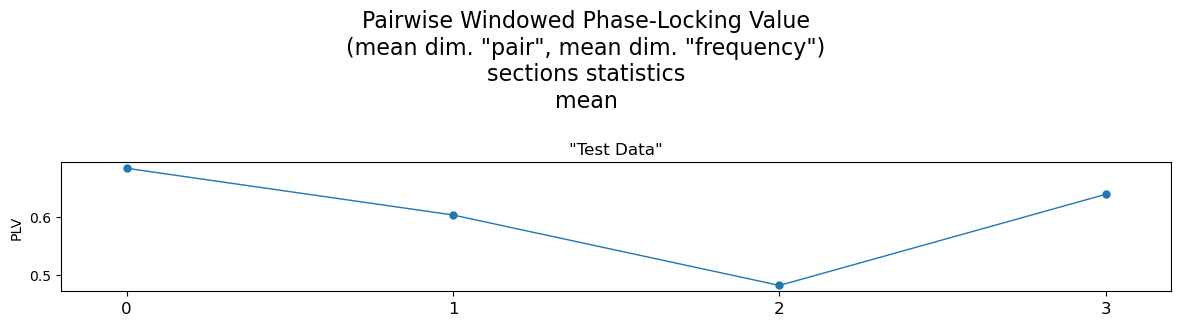

In [9]:
sm = (fft_window_s + plv_window_s)/2
sec_margins = [[sm,sm] for _ in range(4)] # <--- sections' margins (seconds)

wplv_aggr_top_sel_stats = sc.ptdata.secstats( wplv_aggr_top_sel, margins=sec_margins, last=True )
wplv_aggr_top_sel_stats.visualise( statistics='mean' )
print('means =','['+', '.join([str(v) for v in np.round(wplv_aggr_top_sel_stats.data[0][0],3)])+']')

import matplotlib.pyplot as plt
plt.xlim((-0.2,3.2))
plt.xticks((0,1,2,3),('0','1','2','3'),fontsize=12);